In [1]:
import os
import re
from scipy import ndimage, misc
from skimage.transform import resize, rescale
from matplotlib import pyplot
import matplotlib.pyplot as plt
import numpy as np
np.random.seed(0)

from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.layers import Conv2DTranspose, UpSampling2D, add
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers
import tensorflow as tf
print(tf.__version__)

2.12.0


Creating The Encoder

In [11]:
Input_Image = Input(shape=(256,256,4))
layer_1 = Conv2D(64,(3,3),padding = 'same',activation = 'relu',
                 activity_regularizer = regularizers.l1(10e-10))(Input_Image)

layer_2 = Conv2D(64,(3,3),padding = 'same',activation = 'relu',
                 activity_regularizer = regularizers.l1(10e-10))(layer_1)

layer_3 = MaxPooling2D(padding='same')(layer_2)

layer_4 = Conv2D(128,(3,3),padding = 'same',activation = 'relu',
                 activity_regularizer = regularizers.l1(10e-10))(layer_3)

layer_5 = Conv2D(128,(3,3),padding = 'same',activation = 'relu',
                 activity_regularizer = regularizers.l1(10e-10))(layer_4)

layer_6 = MaxPooling2D(padding='same')(layer_5)

layer_7 = Conv2D(128,(3,3),padding = 'same',activation = 'relu',
                 activity_regularizer = regularizers.l1(10e-10))(layer_6)

encoder = Model(Input_Image,layer_7)





In [12]:
encoder.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 4)]     0         
                                                                 
 conv2d_10 (Conv2D)          (None, 256, 256, 64)      2368      
                                                                 
 conv2d_11 (Conv2D)          (None, 256, 256, 64)      36928     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 128, 128, 64)     0         
 2D)                                                             
                                                                 
 conv2d_12 (Conv2D)          (None, 128, 128, 128)     73856     
                                                                 
 conv2d_13 (Conv2D)          (None, 128, 128, 128)     147584    
                                                           

Creating the Decoder

In [13]:

layer_8 = UpSampling2D()(layer_7)
layer_9 = Conv2D(128,(3,3),padding='same',activation='relu',
           activity_regularizer=regularizers.l1(10e-10))(layer_8)
layer_10 = Conv2D(128,(3,3),padding='same',activation='relu',
           activity_regularizer=regularizers.l1(10e-10))(layer_9)
layer_11 = add([layer_5,layer_10])
layer_12 = UpSampling2D()(layer_11)
layer_13 = Conv2D(64,(3,3),padding='same',activation='relu',
           activity_regularizer=regularizers.l1(10e-10))(layer_12)
layer_14 = Conv2D(64,(3,3),padding='same',activation='relu',
           activity_regularizer=regularizers.l1(10e-10))(layer_13)
layer_15 = add([layer_14,layer_2])
decoded = Conv2D(3,(3,3),padding='same',activation='relu',
           activity_regularizer=regularizers.l1(10e-10))(layer_15)
autoencoder = Model(Input_Image,decoded)
autoencoder.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 4  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_10 (Conv2D)             (None, 256, 256, 64  2368        ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_11 (Conv2D)             (None, 256, 256, 64  36928       ['conv2d_10[0][0]']              
                                )                                                           

In [14]:
autoencoder.compile(optimizer='adadelta',loss='mean_squared_error')

In [18]:
def train_batches(just_load_dataset=False):
    
    batches = 256

    batch = 0 
    batch_nb = 0 
    max_batches = 10 
    
    ep = 4 

    images = []
    x_train_n = []
    x_train_down = []
    
    x_train_n2 = [] 
    x_train_down2 = []
    
    for root, dirnames, filenames in os.walk(r"C:\Users\aakas\Desktop\projects\image_super_res\train_images\cars_train\cars_train"):
        for filename in filenames:
            if re.search("\.(jpg|jpeg|JPEG|png|bmp|tiff)$", filename):
                if batch_nb == max_batches: 
                    return x_train_n2, x_train_down2
                filepath = os.path.join(root, filename)
                image = pyplot.imread(filepath)
                if len(image.shape) > 2:
                        
                    image_resized = resize(image, (256, 256))
                    x_train_n.append(image_resized)
                    x_train_down.append(rescale(rescale(image_resized, 0.5), 2.0))
                    batch += 1
                    if batch == batches:
                        batch_nb += 1

                        x_train_n2 = np.array(x_train_n)
                        x_train_down2 = np.array(x_train_down)
                        
                        if just_load_dataset:
                            return x_train_n2, x_train_down2
                        
                        print('Training batch', batch_nb, '(', batches, ')')

                        autoencoder.fit(x_train_down2, x_train_n2,
                            epochs=ep,
                            batch_size=10,
                            shuffle=True,
                            validation_split=0.15)
                    
                        x_train_n = []
                        x_train_down = []
                    
                        batch = 0

    return x_train_n2, x_train_down2

In [19]:
x_train_n, x_train_down = train_batches(just_load_dataset=False) 

Training batch 1 ( 256 )
Epoch 1/4
22/22 [==============================] - 130s 6s/step - loss: 0.0147 - val_loss: 0.0165
Epoch 2/4
22/22 [==============================] - 130s 6s/step - loss: 0.0147 - val_loss: 0.0165
Epoch 3/4
22/22 [==============================] - 128s 6s/step - loss: 0.0146 - val_loss: 0.0164
Epoch 4/4
22/22 [==============================] - 128s 6s/step - loss: 0.0145 - val_loss: 0.0163
Training batch 2 ( 256 )
Epoch 1/4
22/22 [==============================] - 127s 6s/step - loss: 0.0145 - val_loss: 0.0144
Epoch 2/4
22/22 [==============================] - 127s 6s/step - loss: 0.0144 - val_loss: 0.0143
Epoch 3/4
22/22 [==============================] - 127s 6s/step - loss: 0.0144 - val_loss: 0.0143
Epoch 4/4
22/22 [==============================] - 127s 6s/step - loss: 0.0143 - val_loss: 0.0142
Training batch 3 ( 256 )
Epoch 1/4
22/22 [==============================] - 127s 6s/step - loss: 0.0148 - val_loss: 0.0164
Epoch 2/4
22/22 [==========================

In [20]:
sr1 = np.clip(autoencoder.predict(x_train_down), 0.0, 1.0)

8/8 [==============================] - 23s 3s/step


In [27]:
image_index = 250

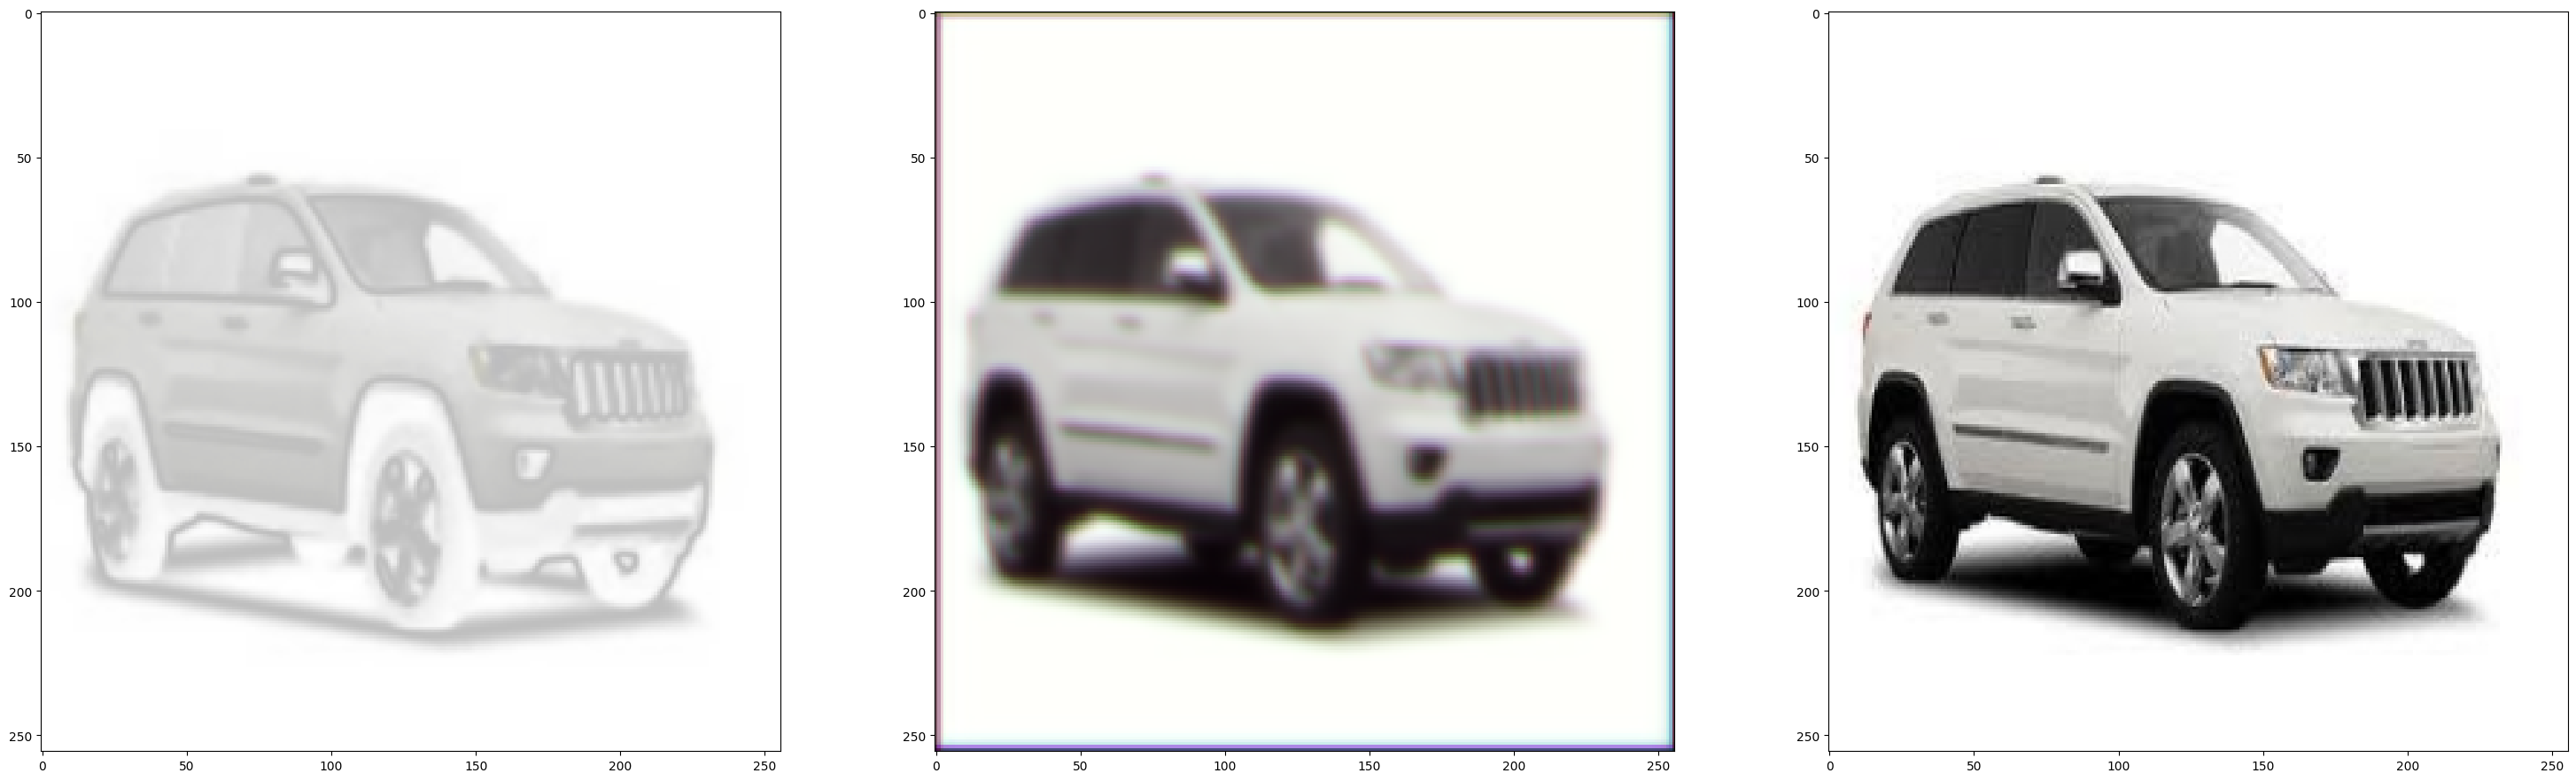

In [34]:
plt.figure(figsize=(128, 128))
i = 1
ax = plt.subplot(10, 10, i)
plt.imshow(x_train_down[image_index])
i += 1
ax = plt.subplot(10, 10, i)
plt.imshow(sr1[image_index])
i += 1
ax = plt.subplot(10, 10, i)
plt.imshow(x_train_n[image_index])
plt.show()